# Research Question A

This notebook tries to find an answer to the research question "How can INRs be trained effectively to facilitate down-stream image processing tasks?" by implementing 3 experiments:
1. How does the activation function affect effective training of INRs?
2. How does number of neurons at hidden layers affect effective training of INRs?
3. How does number of hidden layers affect effective training of INRs?

**Make sure to enable GPU runtime in Colab: Runtime → Change runtime type → Hardware accelerator → GPU**


In [1]:
!git clone https://github.com/vsitzmann/siren.git

fatal: destination path 'siren' already exists and is not an empty directory.


In [2]:
!pip install scikit-video
!pip install cmapy
!pip install configparse
!pip install configargparse

In [3]:
import sys
import os
import subprocess

# Setup imports
sys.path.append('./siren')

import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from functools import partial
from tqdm import tqdm
from PIL import Image
import skimage


# Import SIREN modules
import dataio, meta_modules, utils, training, loss_functions, modules


# Set device and verify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


/content/./siren/training.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Load and Prepare Image


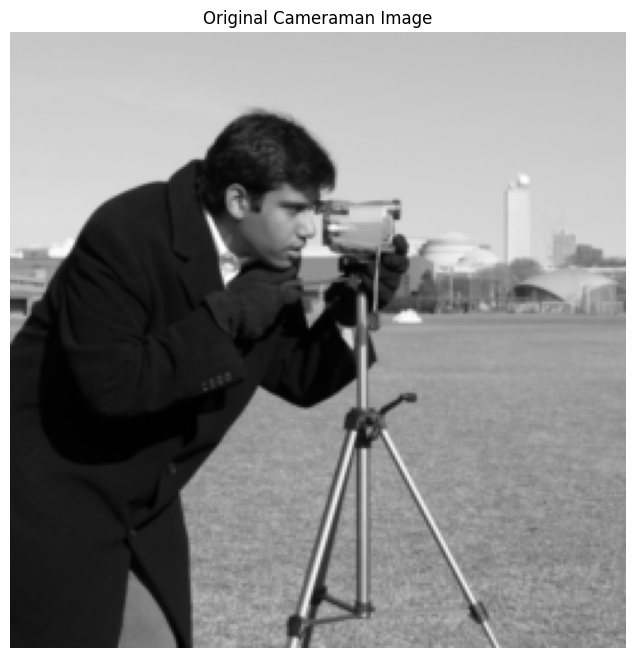

In [4]:
# Configuration
image_resolution = 256

# Create dataset
img_dataset = dataio.Camera()
coord_dataset = dataio.Implicit2DWrapper(img_dataset, sidelength=image_resolution)

# Create dataloader
dataloader = DataLoader(coord_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

# Get image data and use actual channel count
target_channels = img_dataset.img_channels

for model_input, gt in dataloader:
    original_img = gt['img'].view(image_resolution, image_resolution, target_channels).permute(2, 0, 1)
    break

plt.figure(figsize=(8, 8))
if target_channels == 1:
    img_display = (original_img.squeeze() + 1) / 2
    plt.imshow(img_display.clamp(0, 1), cmap='gray')
else:
    img_display = (original_img.permute(1, 2, 0) + 1) / 2
    plt.imshow(img_display.clamp(0, 1))
plt.title('Original Cameraman Image')
plt.axis('off')
plt.show()


## 2. Define Activation Functions to Compare


In [24]:
# Research Question: How can INRs be trained effectively?
activation_functions = {
    'sine': 'SIREN (Sinusoidal)',
    'relu': 'ReLU',
    'tanh': 'Tanh'
}

hidden_features_options = [128, 256, 512]
hidden_layers_options = [1, 2, 3, 4]


base_config = {
    'num_epochs': 10000,
    'learning_rate': 1e-4,
    'hidden_features': 256,
    'num_hidden_layers': 3,
    'steps_til_summary': 200
}

In [16]:
# Create model using the modules from the official repo of SIREN
def create_siren_model(activation_type, image_resolution, hidden_features=256, num_hidden_layers=3):
    model = modules.SingleBVPNet(
        type=activation_type,
        mode='mlp',
        sidelength=(image_resolution, image_resolution),
        in_features=2,
        out_features=target_channels,
        hidden_features=hidden_features,
        num_hidden_layers=num_hidden_layers
    )
    return model.to(device)

# Reconstruct image using the modules from the official repo of SIREN
def generate_reconstruction_original(model, image_resolution, device):
    model.eval()
    coords = dataio.get_mgrid(image_resolution)
    coords = coords.unsqueeze(0).to(device)

    with torch.no_grad():
        model_input = {'coords': coords}
        model_output = model(model_input)
        pred_img = model_output['model_out']

    pred_img = pred_img.view(image_resolution, image_resolution, target_channels).permute(2, 0, 1).cpu()
    return pred_img


## 3. Training and Comparison Functions



In [20]:
def train_with_original_functions(model, dataloader, config, model_name):

    loss_fn = partial(loss_functions.image_mse, None)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

    train_losses = []
    metrics = {
        'final_loss': None,
        'training_time': 0,
        'best_loss': float('inf'),
        'epochs_completed': 0,
        'early_stopped': False,
        'stopped_at_epoch': None
    }


    start_time = time.time()

    pbar = tqdm(range(config['num_epochs']), desc=f"Training {model_name}")

    for epoch in pbar:
        epoch_losses = []

        for step, (model_input, gt) in enumerate(dataloader):
            # Move to device
            model_input = {key: value.cuda() for key, value in model_input.items()}
            gt = {key: value.cuda() for key, value in gt.items()}

            # Forward pass
            model_output = model(model_input)

            # Compute loss
            losses = loss_fn(model_output, gt)
            train_loss = losses['img_loss']

            # Backward pass
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            loss_val = train_loss.item()
            epoch_losses.append(loss_val)

            # Track best loss
            if loss_val < metrics['best_loss']:
                metrics['best_loss'] = loss_val

        # Store average loss for this epoch
        avg_epoch_loss = np.mean(epoch_losses)
        train_losses.append(avg_epoch_loss)

        # Absolute loss threshold early stopping (hardcoded)
        if avg_epoch_loss < 1e-5:  # Stop if loss goes below 1e-5
            print(f"\nEarly stopping at epoch {epoch + 1} - loss threshold reached: {avg_epoch_loss:.2e} < 1e-5")
            metrics['early_stopped'] = True
            metrics['stopped_at_epoch'] = epoch + 1
            break

        # Update progress bar
        pbar.set_postfix({'Loss': f'{avg_epoch_loss:.6f}'})

        metrics['epochs_completed'] = epoch + 1

    metrics['training_time'] = time.time() - start_time
    metrics['final_loss'] = train_losses[-1]

    return model, train_losses, metrics



def calculate_image_quality_metrics(original_img, reconstructed_img):
    """Calculate metrics using original SIREN approach"""
    # MSE calculation
    mse = torch.mean((original_img - reconstructed_img) ** 2)

    # PSNR calculation (peak value is 2 for range [-1, 1])
    psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))

    # Additional metrics
    mae = torch.mean(torch.abs(original_img - reconstructed_img))

    return {
        'mse': mse.item(),
        'psnr': psnr.item(),
        'mae': mae.item()
    }

def plot_loss_curve(train_losses, model_name, early_stopped=False, stopped_at_epoch=None):
    """Plot training loss curve with early stopping indication"""
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')

    # Mark early stopping point if applicable
    if early_stopped and stopped_at_epoch:
        plt.axvline(x=stopped_at_epoch, color='r', linestyle='--', alpha=0.7,
                   label=f'Early Stopped (Epoch {stopped_at_epoch})')

    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Training Loss Curve - {model_name}')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Add loss statistics
    initial_loss = train_losses[0]
    final_loss = train_losses[-1]
    min_loss = min(train_losses)

    plt.text(0.02, 0.98, f'Initial Loss: {initial_loss:.6f}\nMin Loss: {min_loss:.6f}',
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()



## 4. Train All Models and Collect Results


EXPERIMENT 1: Activation Function Exploration
Research Question: How do different activation functions affect INR training effectiveness?

Training: SIREN (Sinusoidal)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 198,401


Training SIREN (Sinusoidal):  35%|███▌      | 3513/10000 [01:36<02:58, 36.31it/s, Loss=0.000010]



Early stopping at epoch 3514 - loss threshold reached: 9.92e-06 < 1e-5
Results for SIREN (Sinusoidal):
Final Loss: 0.000010
MSE: 0.000010
PSNR: 56.12 dB
MAE: 0.002249
Training Time: 96.74s
   Early stopped at epoch: 3514
Training Loss Curve for SIREN (Sinusoidal):


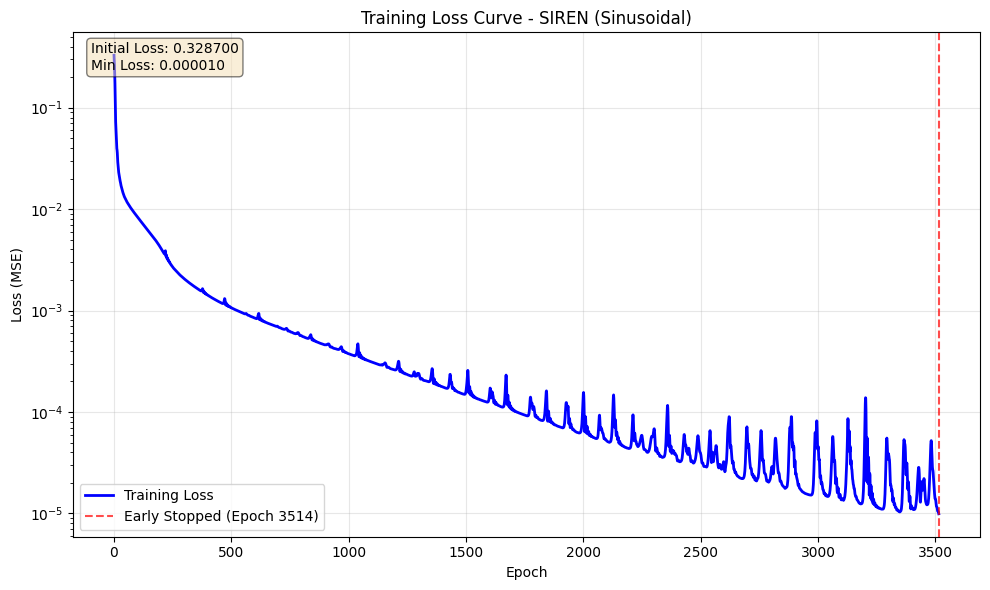

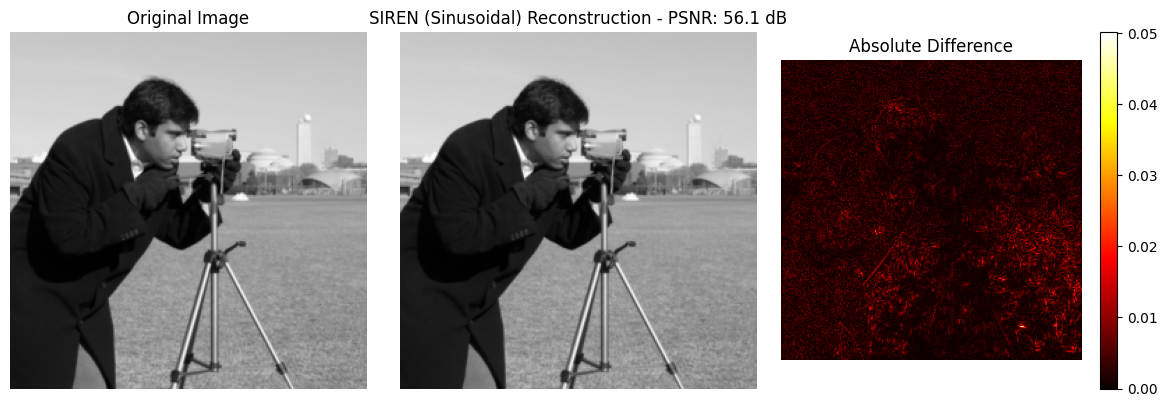


Training: ReLU
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): ReLU(inplace=True)
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 198,401


Training ReLU: 100%|██████████| 10000/10000 [03:25<00:00, 48.72it/s, Loss=0.009505]


Results for ReLU:
Final Loss: 0.009505
MSE: 0.009860
PSNR: 26.08 dB
MAE: 0.068383
Training Time: 205.26s
   Completed all 10000 epochs
Training Loss Curve for ReLU:


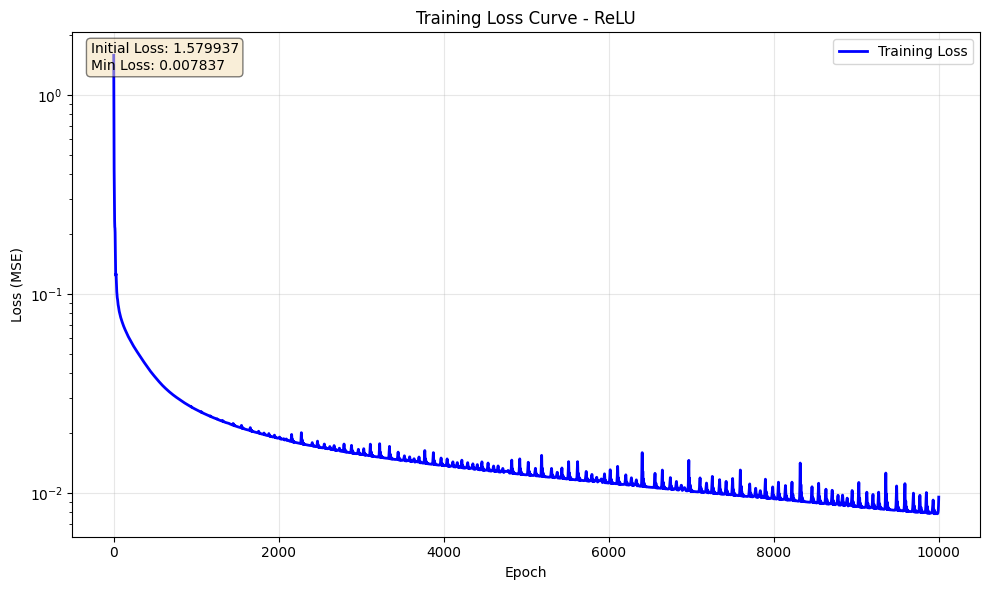

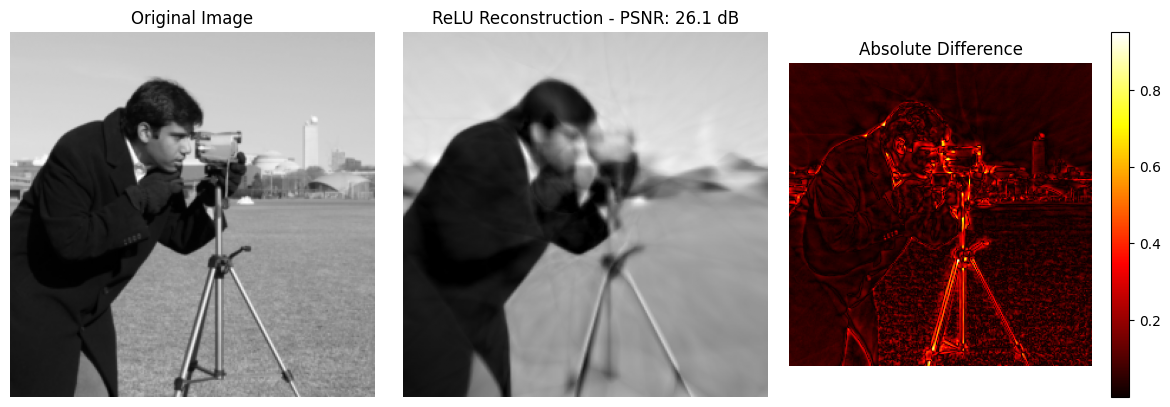


Training: Tanh
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Tanh()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Tanh()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 198,401


Training Tanh: 100%|██████████| 10000/10000 [03:28<00:00, 47.95it/s, Loss=0.015770]


Results for Tanh:
Final Loss: 0.015770
MSE: 0.015785
PSNR: 24.04 dB
MAE: 0.065463
Training Time: 208.54s
   Completed all 10000 epochs
Training Loss Curve for Tanh:


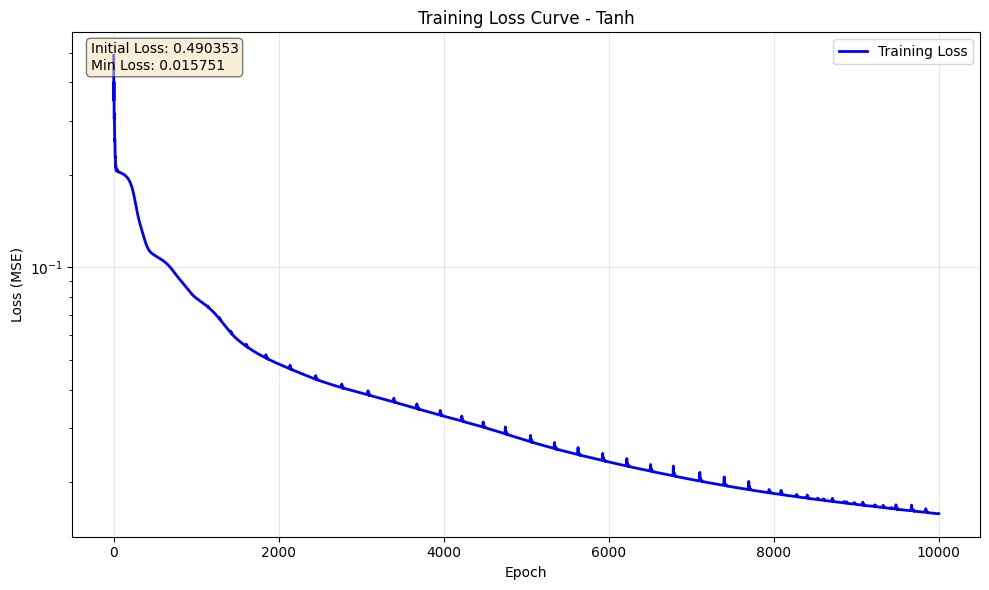

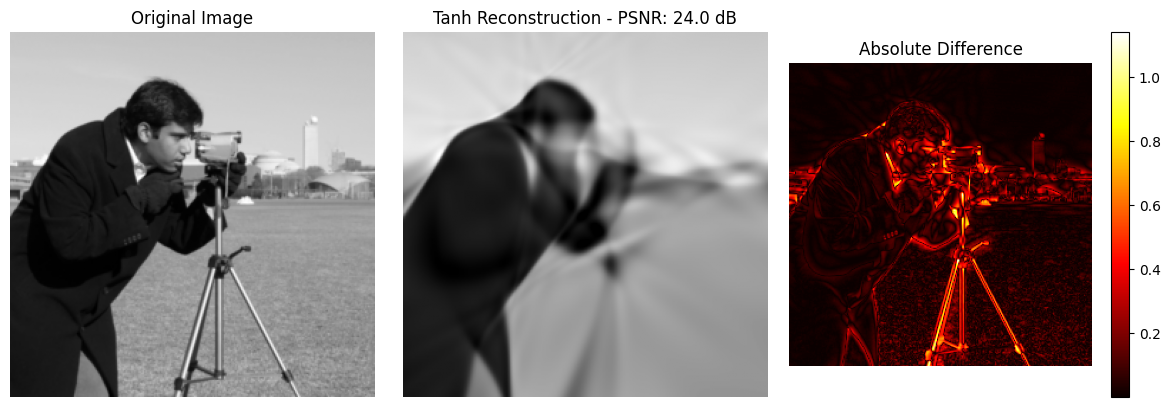

In [21]:
# EXPERIMENT 1: Activation Function Exploration
print("EXPERIMENT 1: Activation Function Exploration")
print("=" * 50)
print("Research Question: How do different activation functions affect INR training effectiveness?")

activation_results = {}
activation_reconstructions = {}

for activation_type, description in activation_functions.items():
    experiment_name = f"{description}"
    print(f"\n{'='*60}")
    print(f"Training: {experiment_name}")
    print(f"{'='*60}")

    try:
        # Create model with current activation
        model = create_siren_model(
            activation_type,
            image_resolution,
            hidden_features=base_config['hidden_features'],
            num_hidden_layers=base_config['num_hidden_layers']
        )

        print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

        # Create config for this experiment
        experiment_config = base_config.copy()
        experiment_config['activation_type'] = activation_type

        # Train model
        trained_model, train_losses, metrics = train_with_original_functions(
            model, dataloader, experiment_config, experiment_name
        )

        # Generate reconstruction
        reconstruction = generate_reconstruction_original(trained_model, image_resolution, device)

        # Calculate quality metrics
        quality_metrics = calculate_image_quality_metrics(original_img, reconstruction)

        # Store results
        activation_results[activation_type] = {
            'description': description,
            'experiment_name': experiment_name,
            'train_losses': train_losses,
            'training_metrics': metrics,
            'quality_metrics': quality_metrics,
            'model_params': sum(p.numel() for p in trained_model.parameters()),
            'config': experiment_config,
            'reconstruction': reconstruction
        }

        activation_reconstructions[activation_type] = reconstruction

        print(f"Results for {description}:")
        print(f"Final Loss: {metrics['final_loss']:.6f}")
        print(f"MSE: {quality_metrics['mse']:.6f}")
        print(f"PSNR: {quality_metrics['psnr']:.2f} dB")
        print(f"MAE: {quality_metrics['mae']:.6f}")
        print(f"Training Time: {metrics['training_time']:.2f}s")
        if metrics['early_stopped']:
            print(f"   Early stopped at epoch: {metrics['stopped_at_epoch']}")
        else:
            print(f"   Completed all {metrics['epochs_completed']} epochs")

        # Plot loss curve
        print(f"Training Loss Curve for {description}:")
        plot_loss_curve(train_losses, description, metrics['early_stopped'], metrics['stopped_at_epoch'])

        # Display reconstruction
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        if target_channels == 1:
            orig_display = (original_img.squeeze() + 1) / 2
            plt.imshow(orig_display.clamp(0, 1), cmap='gray')
        else:
            orig_display = (original_img.permute(1, 2, 0) + 1) / 2
            plt.imshow(orig_display.clamp(0, 1))
        plt.title('Original Image')
        plt.axis('off')

        # Reconstructed image
        plt.subplot(1, 3, 2)
        if target_channels == 1:
            recon_display = (reconstruction.squeeze() + 1) / 2
            plt.imshow(recon_display.clamp(0, 1), cmap='gray')
        else:
            recon_display = (reconstruction.permute(1, 2, 0) + 1) / 2
            plt.imshow(recon_display.clamp(0, 1))
        plt.title(f'{description} Reconstruction - PSNR: {quality_metrics["psnr"]:.1f} dB')
        plt.axis('off')

        # Difference
        plt.subplot(1, 3, 3)
        if target_channels == 1:
            diff = torch.abs(original_img.squeeze() - reconstruction.squeeze())
        else:
            diff = torch.abs(torch.mean(original_img, dim=0) - torch.mean(reconstruction, dim=0))
        plt.imshow(diff, cmap='hot')
        plt.title('Absolute Difference')
        plt.axis('off')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to train {experiment_name}: {e}")
        continue



EXPERIMENT 2: Number of Features in Hidden Layers Exploration
Research Question: How does number of features in hidden layers affect INR training effectiveness?

Training: SIREN-128HF (Hidden Features: 128)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=128, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=128, out_features=128, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=128, out_features=128, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=128, out_features=128, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=128, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 50,049


Training SIREN-128HF: 100%|██████████| 10000/10000 [01:54<00:00, 87.29it/s, Loss=0.000029]


Results for SIREN-128HF:
Final Loss: 0.000029
MSE: 0.000030
PSNR: 51.20 dB
MAE: 0.004049
Training Time: 114.57s
Parameters: 50,049
Completed all 10000 epochs
Training Loss Curve for SIREN-128HF:


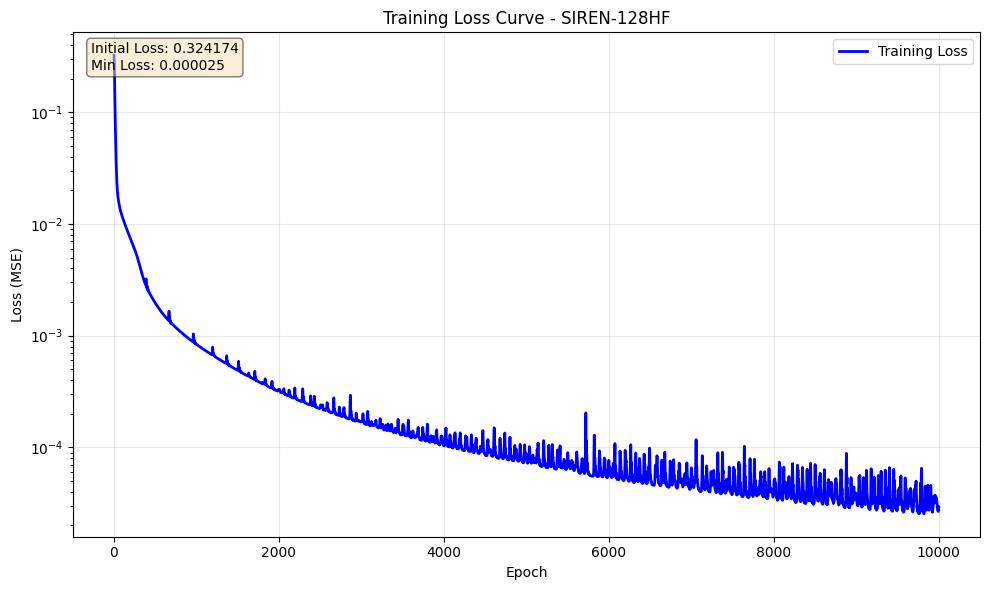

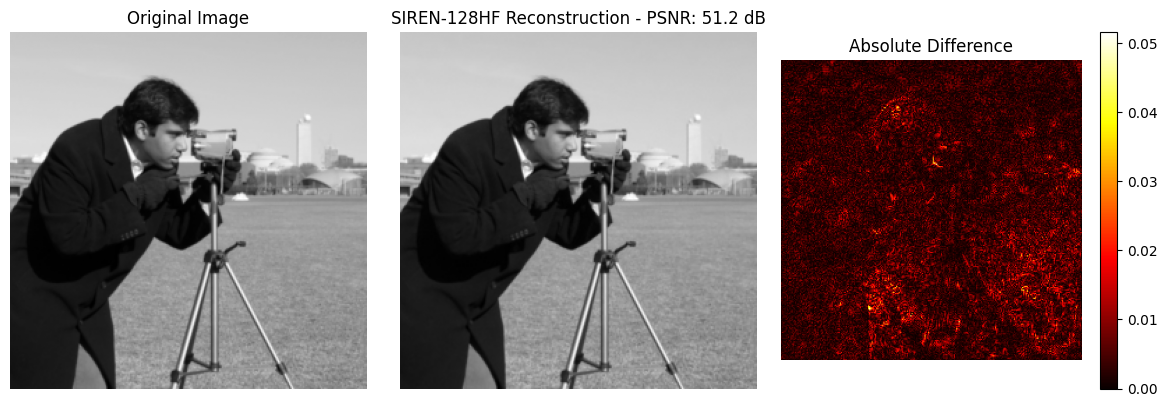


Training: SIREN-256HF (Hidden Features: 256)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 198,401


Training SIREN-256HF:  38%|███▊      | 3805/10000 [01:45<02:51, 36.10it/s, Loss=0.000010]



Early stopping at epoch 3806 - loss threshold reached: 9.93e-06 < 1e-5
Results for SIREN-256HF:
Final Loss: 0.000010
MSE: 0.000010
PSNR: 56.11 dB
MAE: 0.002234
Training Time: 105.39s
Parameters: 198,401
Early stopped at epoch: 3806
Training Loss Curve for SIREN-256HF:


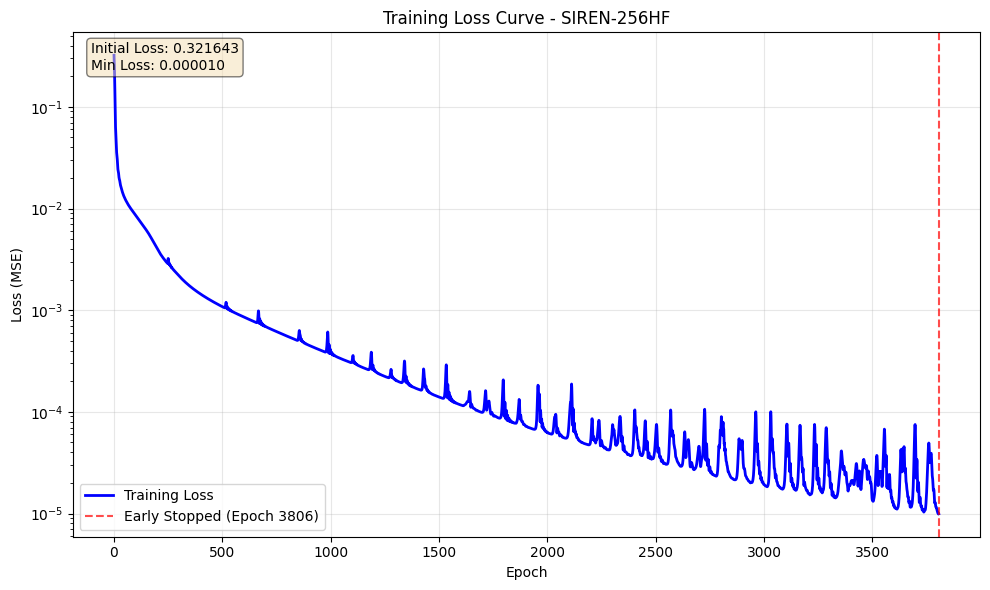

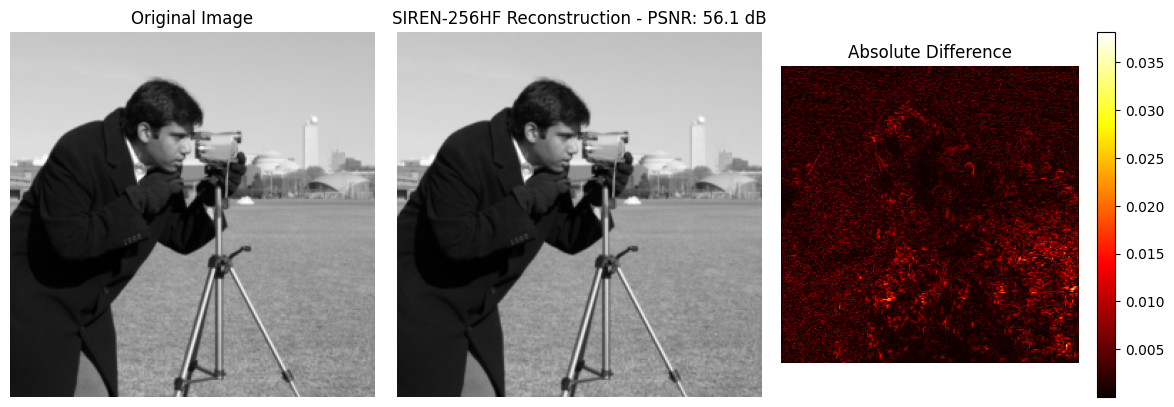


Training: SIREN-512HF (Hidden Features: 512)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=512, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=512, out_features=512, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=512, out_features=512, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=512, out_features=512, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=512, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 790,017


Training SIREN-512HF:  17%|█▋        | 1692/10000 [01:51<09:08, 15.15it/s, Loss=0.000010]



Early stopping at epoch 1693 - loss threshold reached: 9.81e-06 < 1e-5
Results for SIREN-512HF:
Final Loss: 0.000010
MSE: 0.000010
PSNR: 56.20 dB
MAE: 0.002141
Training Time: 111.70s
Parameters: 790,017
Early stopped at epoch: 1693
Training Loss Curve for SIREN-512HF:


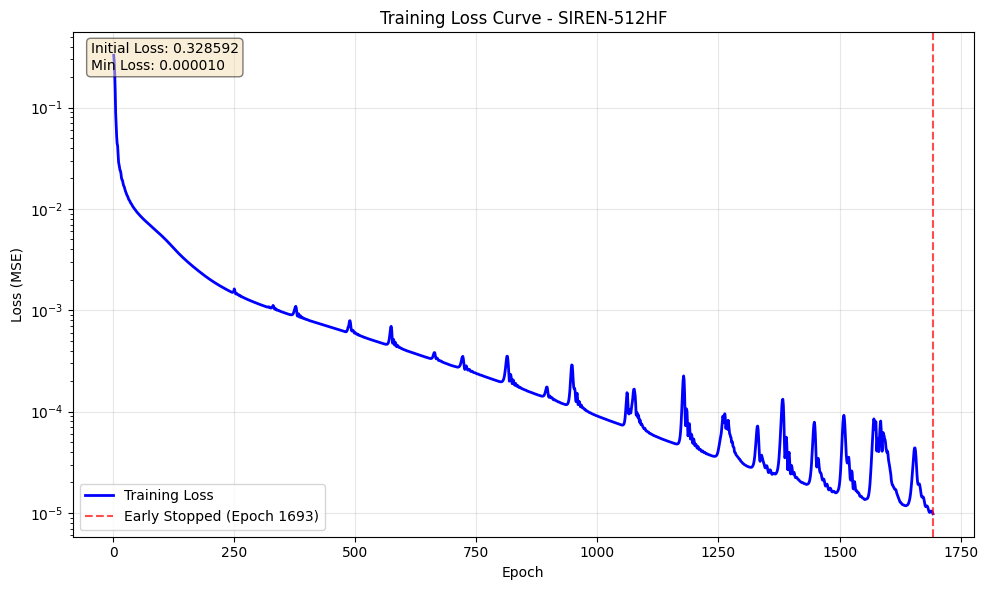

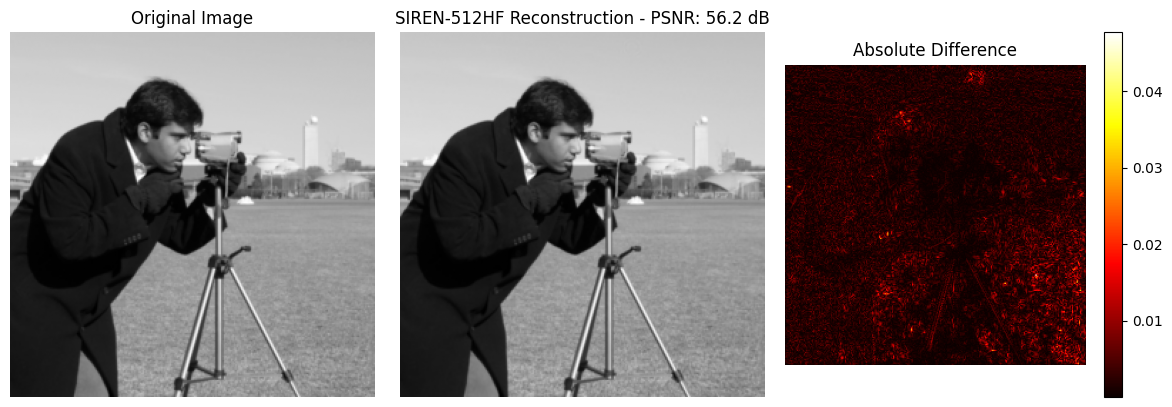

In [22]:
# EXPERIMENT 2: Hidden Features (Network Width) Exploration
print("EXPERIMENT 2: Number of Features in Hidden Layers Exploration")
print("=" * 50)
print("Research Question: How does number of features in hidden layers affect INR training effectiveness?")

# Use SIREN as baseline activation for this experiment
baseline_activation = 'sine'
hidden_features_results = {}

for hidden_features in hidden_features_options:
    experiment_name = f"SIREN-{hidden_features}HF"
    print(f"\n{'='*60}")
    print(f"Training: {experiment_name} (Hidden Features: {hidden_features})")
    print(f"{'='*60}")

    try:
        # Create model with varying hidden features
        model = create_siren_model(
            baseline_activation,
            image_resolution,
            hidden_features=hidden_features,
            num_hidden_layers=base_config['num_hidden_layers']
        )

        print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

        # Create config for this experiment
        experiment_config = base_config.copy()
        experiment_config['hidden_features'] = hidden_features

        # Train model
        trained_model, train_losses, metrics = train_with_original_functions(
            model, dataloader, experiment_config, experiment_name
        )

        # Generate reconstruction
        reconstruction = generate_reconstruction_original(trained_model, image_resolution, device)

        # Calculate quality metrics
        quality_metrics = calculate_image_quality_metrics(original_img, reconstruction)

        # Store results
        hidden_features_results[hidden_features] = {
            'experiment_name': experiment_name,
            'train_losses': train_losses,
            'training_metrics': metrics,
            'quality_metrics': quality_metrics,
            'model_params': sum(p.numel() for p in trained_model.parameters()),
            'config': experiment_config,
            'reconstruction': reconstruction
        }

        print(f"Results for {experiment_name}:")
        print(f"Final Loss: {metrics['final_loss']:.6f}")
        print(f"MSE: {quality_metrics['mse']:.6f}")
        print(f"PSNR: {quality_metrics['psnr']:.2f} dB")
        print(f"MAE: {quality_metrics['mae']:.6f}")
        print(f"Training Time: {metrics['training_time']:.2f}s")
        print(f"Parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
        if metrics['early_stopped']:
            print(f"Early stopped at epoch: {metrics['stopped_at_epoch']}")
        else:
            print(f"Completed all {metrics['epochs_completed']} epochs")

        # Plot loss curve
        print(f"Training Loss Curve for {experiment_name}:")
        plot_loss_curve(train_losses, experiment_name, metrics['early_stopped'], metrics['stopped_at_epoch'])

        # Display reconstruction
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        if target_channels == 1:
            orig_display = (original_img.squeeze() + 1) / 2
            plt.imshow(orig_display.clamp(0, 1), cmap='gray')
        else:
            orig_display = (original_img.permute(1, 2, 0) + 1) / 2
            plt.imshow(orig_display.clamp(0, 1))
        plt.title('Original Image')
        plt.axis('off')

        # Reconstructed image
        plt.subplot(1, 3, 2)
        if target_channels == 1:
            recon_display = (reconstruction.squeeze() + 1) / 2
            plt.imshow(recon_display.clamp(0, 1), cmap='gray')
        else:
            recon_display = (reconstruction.permute(1, 2, 0) + 1) / 2
            plt.imshow(recon_display.clamp(0, 1))
        plt.title(f'{experiment_name} Reconstruction - PSNR: {quality_metrics["psnr"]:.1f} dB')
        plt.axis('off')

        # Difference
        plt.subplot(1, 3, 3)
        if target_channels == 1:
            diff = torch.abs(original_img.squeeze() - reconstruction.squeeze())
        else:
            diff = torch.abs(torch.mean(original_img, dim=0) - torch.mean(reconstruction, dim=0))
        plt.imshow(diff, cmap='hot')
        plt.title('Absolute Difference')
        plt.axis('off')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to train {experiment_name}: {e}")
        continue



EXPERIMENT 3: Hidden Layers  Exploration
Research Question: How does number of hidden layers affect INR training effectiveness?

Training: SIREN-1HL (Hidden Layers: 1)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 66,817


Training SIREN-1HL: 100%|██████████| 10000/10000 [02:28<00:00, 67.55it/s, Loss=0.000486]


Results for SIREN-1HL:
Final Loss: 0.000486
MSE: 0.000486
PSNR: 39.15 dB
MAE: 0.014274
Training Time: 148.04s
Parameters: 66,817
   Completed all 10000 epochs
Training Loss Curve for SIREN-1HL:


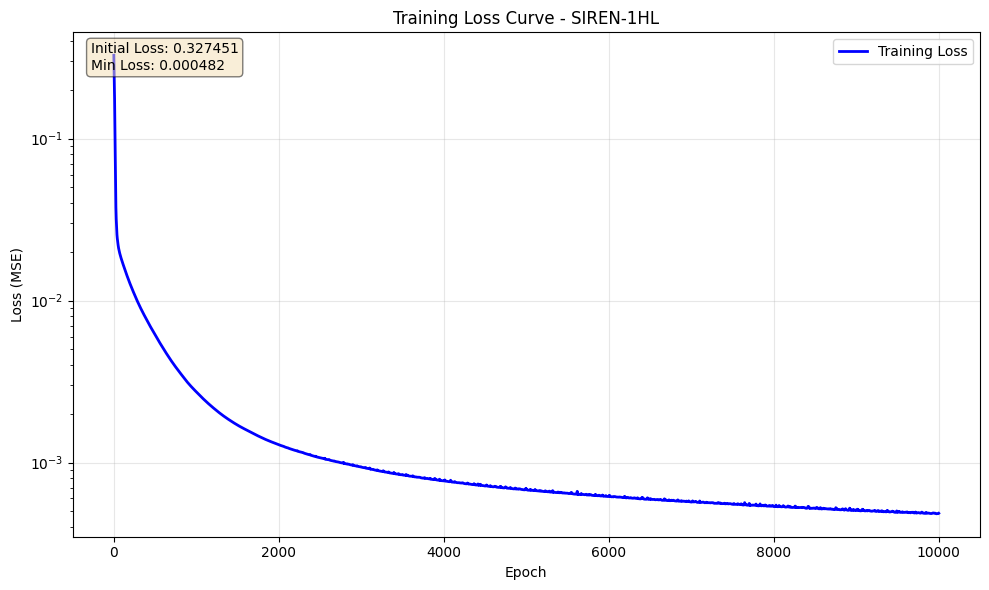

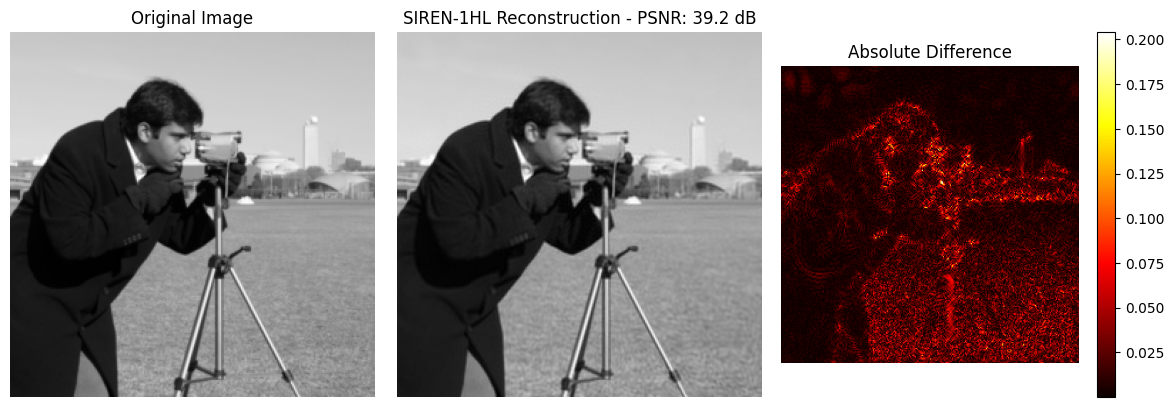


Training: SIREN-2HL (Hidden Layers: 2)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 132,609


Training SIREN-2HL: 100%|██████████| 10000/10000 [03:32<00:00, 46.98it/s, Loss=0.000017]


Results for SIREN-2HL:
Final Loss: 0.000017
MSE: 0.000016
PSNR: 53.99 dB
MAE: 0.003006
Training Time: 212.84s
Parameters: 132,609
   Completed all 10000 epochs
Training Loss Curve for SIREN-2HL:


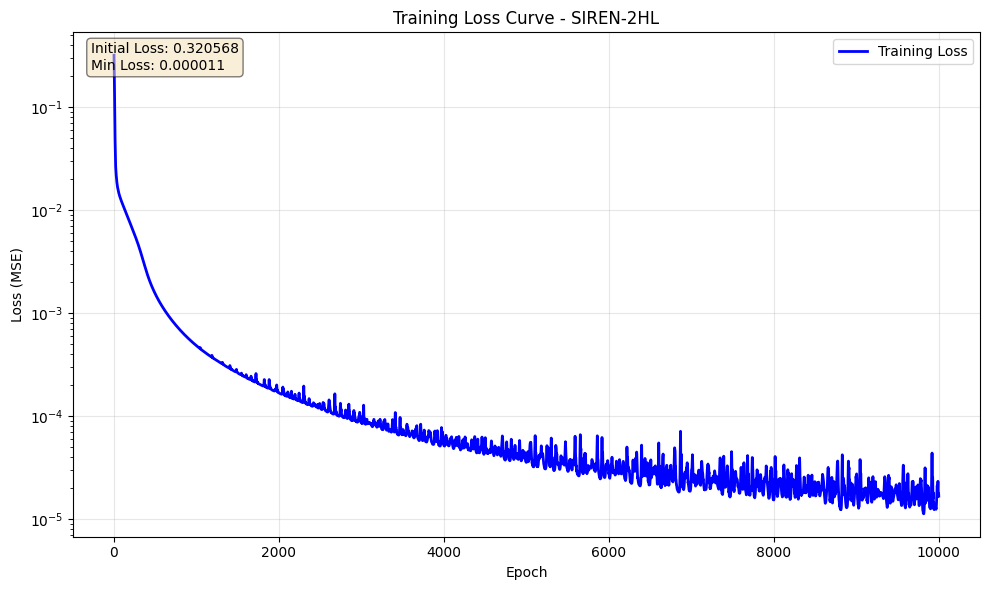

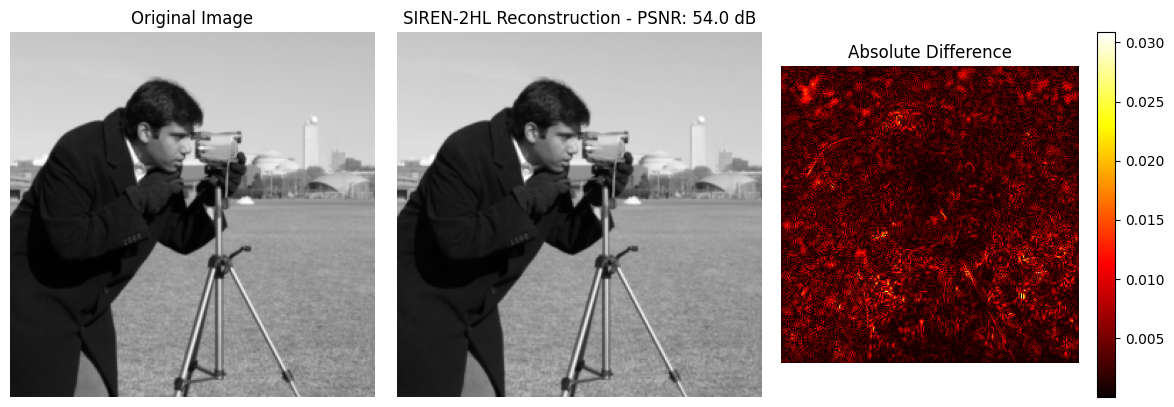


Training: SIREN-3HL (Hidden Layers: 3)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 198,401


Training SIREN-3HL:  40%|███▉      | 3967/10000 [01:49<02:46, 36.13it/s, Loss=0.000010]



Early stopping at epoch 3968 - loss threshold reached: 9.98e-06 < 1e-5
Results for SIREN-3HL:
Final Loss: 0.000010
MSE: 0.000010
PSNR: 56.03 dB
MAE: 0.002247
Training Time: 109.80s
Parameters: 198,401
   Early stopped at epoch: 3968
Training Loss Curve for SIREN-3HL:


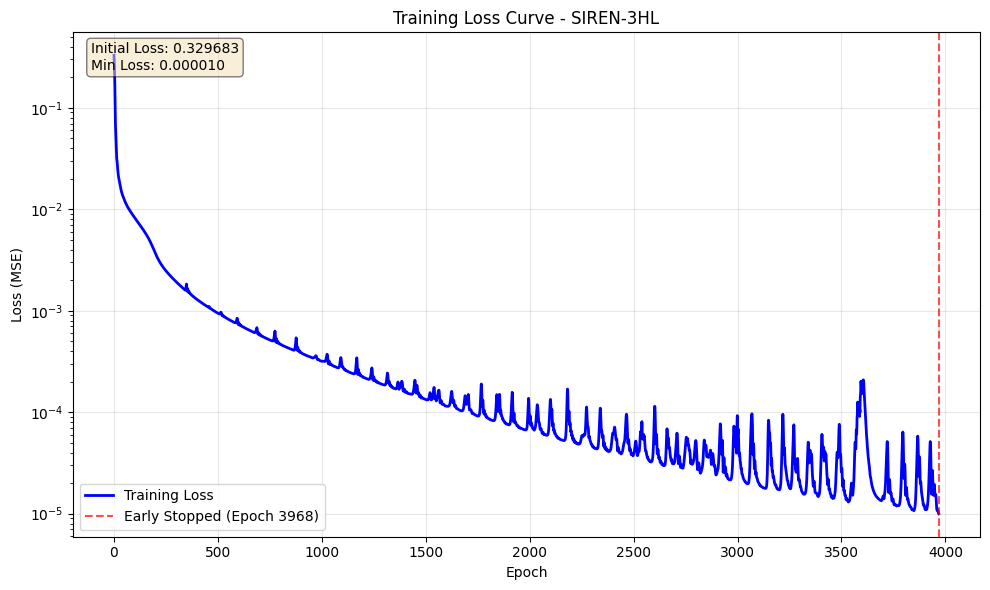

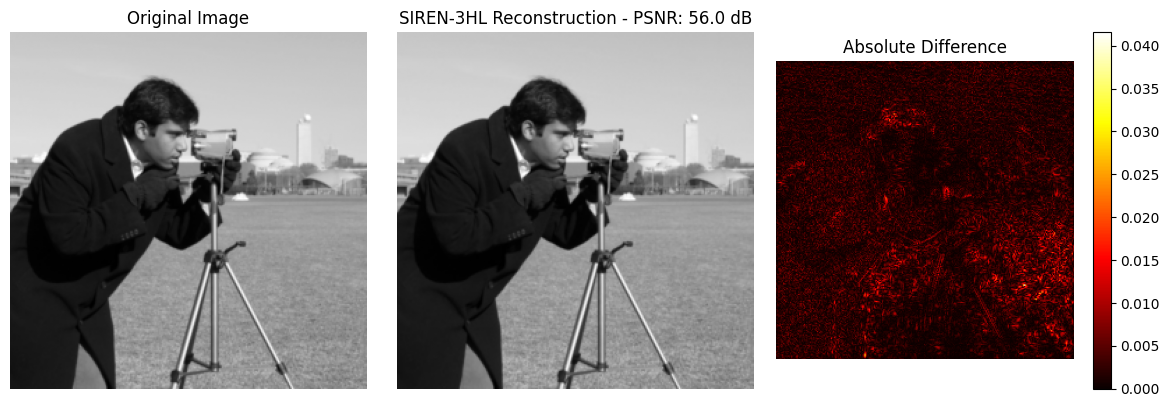


Training: SIREN-4HL (Hidden Layers: 4)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (5): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)
Model parameters: 264,193


Training SIREN-4HL:  28%|██▊       | 2781/10000 [01:34<04:05, 29.37it/s, Loss=0.000010]



Early stopping at epoch 2782 - loss threshold reached: 9.94e-06 < 1e-5
Results for SIREN-4HL:
Final Loss: 0.000010
MSE: 0.000010
PSNR: 56.11 dB
MAE: 0.002275
Training Time: 94.68s
Parameters: 264,193
   Early stopped at epoch: 2782
Training Loss Curve for SIREN-4HL:


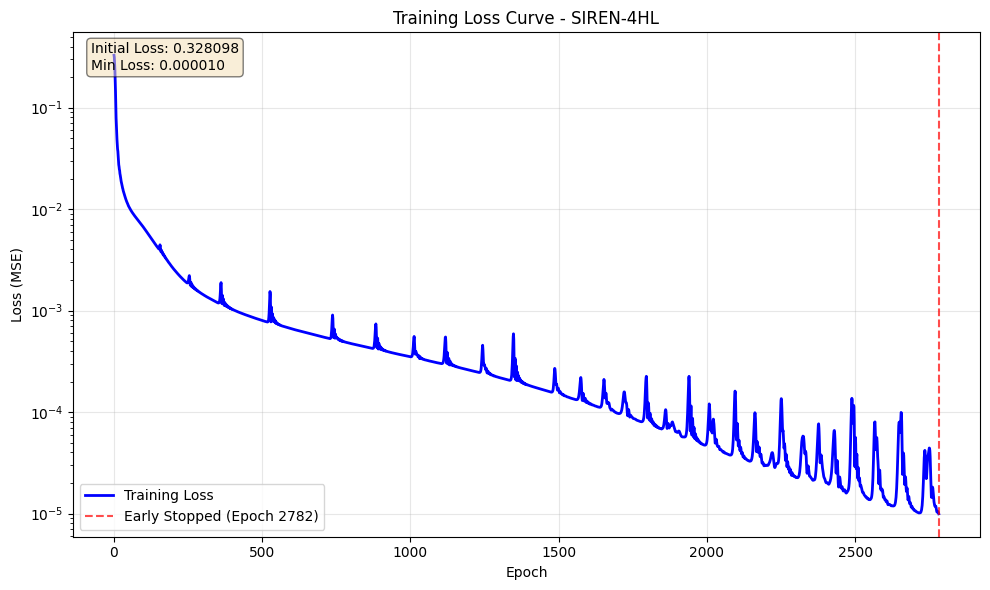

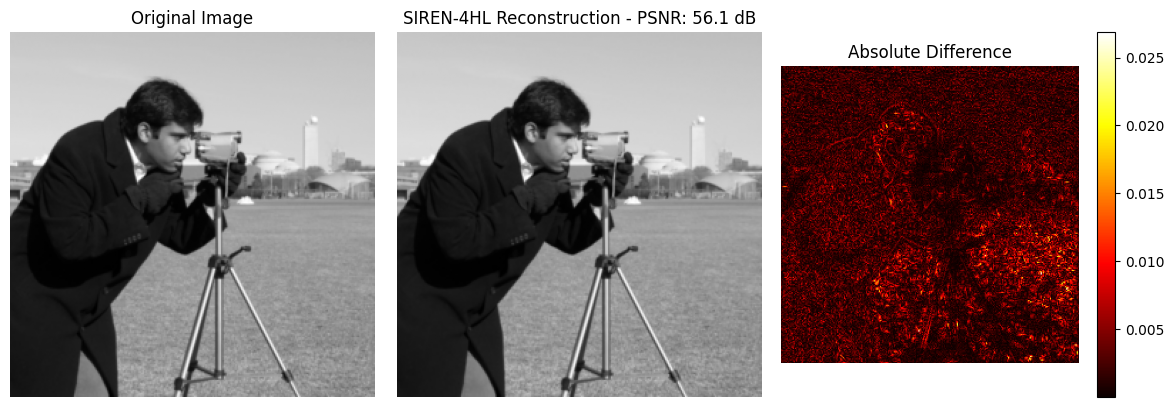

In [25]:
# EXPERIMENT 3: Hidden Layers (Network Depth) Exploration
print("EXPERIMENT 3: Hidden Layers  Exploration")
print("=" * 50)
print("Research Question: How does number of hidden layers affect INR training effectiveness?")

# Use SIREN (sine) as baseline activation for this experiment
hidden_layers_results = {}

for num_hidden_layers in hidden_layers_options:
    experiment_name = f"SIREN-{num_hidden_layers}HL"
    print(f"\n{'='*60}")
    print(f"Training: {experiment_name} (Hidden Layers: {num_hidden_layers})")
    print(f"{'='*60}")

    try:
        # Create model with varying hidden layers
        model = create_siren_model(
            baseline_activation,
            image_resolution,
            hidden_features=base_config['hidden_features'],
            num_hidden_layers=num_hidden_layers
        )

        print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

        # Create config for this experiment
        experiment_config = base_config.copy()
        experiment_config['num_hidden_layers'] = num_hidden_layers

        # Train model
        trained_model, train_losses, metrics = train_with_original_functions(
            model, dataloader, experiment_config, experiment_name
        )

        # Generate reconstruction
        reconstruction = generate_reconstruction_original(trained_model, image_resolution, device)

        # Calculate quality metrics
        quality_metrics = calculate_image_quality_metrics(original_img, reconstruction)

        # Store results
        hidden_layers_results[num_hidden_layers] = {
            'experiment_name': experiment_name,
            'train_losses': train_losses,
            'training_metrics': metrics,
            'quality_metrics': quality_metrics,
            'model_params': sum(p.numel() for p in trained_model.parameters()),
            'config': experiment_config,
            'reconstruction': reconstruction
        }

        print(f"Results for {experiment_name}:")
        print(f"Final Loss: {metrics['final_loss']:.6f}")
        print(f"MSE: {quality_metrics['mse']:.6f}")
        print(f"PSNR: {quality_metrics['psnr']:.2f} dB")
        print(f"MAE: {quality_metrics['mae']:.6f}")
        print(f"Training Time: {metrics['training_time']:.2f}s")
        print(f"Parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
        if metrics['early_stopped']:
            print(f"   Early stopped at epoch: {metrics['stopped_at_epoch']}")
        else:
            print(f"   Completed all {metrics['epochs_completed']} epochs")

        # Plot loss curve
        print(f"Training Loss Curve for {experiment_name}:")
        plot_loss_curve(train_losses, experiment_name, metrics['early_stopped'], metrics['stopped_at_epoch'])

        # Display reconstruction
        plt.figure(figsize=(12, 4))

        # Original image
        plt.subplot(1, 3, 1)
        if target_channels == 1:
            orig_display = (original_img.squeeze() + 1) / 2
            plt.imshow(orig_display.clamp(0, 1), cmap='gray')
        else:
            orig_display = (original_img.permute(1, 2, 0) + 1) / 2
            plt.imshow(orig_display.clamp(0, 1))
        plt.title('Original Image')
        plt.axis('off')

        # Reconstructed image
        plt.subplot(1, 3, 2)
        if target_channels == 1:
            recon_display = (reconstruction.squeeze() + 1) / 2
            plt.imshow(recon_display.clamp(0, 1), cmap='gray')
        else:
            recon_display = (reconstruction.permute(1, 2, 0) + 1) / 2
            plt.imshow(recon_display.clamp(0, 1))
        plt.title(f'{experiment_name} Reconstruction - PSNR: {quality_metrics["psnr"]:.1f} dB')
        plt.axis('off')

        # Difference
        plt.subplot(1, 3, 3)
        if target_channels == 1:
            diff = torch.abs(original_img.squeeze() - reconstruction.squeeze())
        else:
            diff = torch.abs(torch.mean(original_img, dim=0) - torch.mean(reconstruction, dim=0))
        plt.imshow(diff, cmap='hot')
        plt.title('Absolute Difference')
        plt.axis('off')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to train {experiment_name}: {e}")
        continue

